In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
from joblib import dump, load 

In [2]:
gr = pd.read_csv('gr_metadata_sample.csv')
am = pd.read_csv('am_metadata_sample.csv')
am_gr = pd.merge(gr[['asin', 'average_rating', 'total_ratings_count', 'total_text_reviews_count', 'publication_year', 
                     'publication_month', 'publication_day', 'num_pages', 'format', 'cleaned_description', 'gr_countDes_before', 
                     'gr_countDes_after', 'cleaned_genres', 'gr_countText_before', 'gr_countText_after']], 
                 am[['asin', 'average', 'rating_count', 'text_reviews_count', 'rank', 'verifiedTrue_count', 'Format',
                     'am_countText_before', 'am_countText_after']], how='inner', on='asin')

In [3]:
am_gr = am_gr.rename(columns={'average_rating':'gr_average', 'total_ratings_count':'gr_ratings_count',
                              'total_text_reviews_count':'gr_reviews_count', 'publication_year':'gr_pub_yr', 
                              'publication_month':'gr_pub_mo', 'publication_day':'gr_pub_day', 'num_pages':'gr_num_pages', 
                              'format':'gr_format', 'cleaned_description':'gr_description', 'cleaned_genres':'gr_genres',
                              'average':'am_average', 'rating_count':'am_ratings_count', 'text_reviews_count':'am_reviews_count', 
                              'rank':'am_rank', 'verifiedTrue_count':'am_verifiedTrue_count', 'Format':'am_format'})

In [4]:
lda_mallet = pd.read_csv('am_gr_LDA_sample.csv')
lda_mallet = lda_mallet.drop('delete', axis=1)

# Clean Data

In [5]:
am_gr.describe()

,gr_average,gr_ratings_count,gr_reviews_count,gr_pub_yr,gr_pub_mo,gr_pub_day,gr_num_pages,gr_countDes_before,gr_countDes_after,gr_countText_before,gr_countText_after,am_average,am_ratings_count,am_reviews_count,am_rank,am_verifiedTrue_count,am_countText_before,am_countText_after
count,4958.000000,4.958000e+03,4958.000000,4768.000000,4613.000000,4560.000000,4735.000000,4800.000000,4647.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4.958000e+03,4958.000000,4.958000e+03,4.958000e+03
mean,3.904893,1.974577e+04,818.274102,2002.208473,6.320616,13.507237,329.899472,149.816458,81.733161,2011.212182,890.661154,4.259697,205.451392,205.403792,2.262237e+06,141.943324,1.713174e+04,8.084393e+03
std,0.291798,1.295549e+05,3803.279868,9.533428,3.373176,10.795003,225.328095,96.031105,53.493332,7641.103881,3332.235766,0.429768,1020.912069,1020.653953,2.870740e+06,847.904886,6.431560e+04,2.970316e+04
min,2.380000,7.000000e+00,1.000000,1900.000000,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.710000,6.000000,6.000000,3.460000e+02,0.000000,1.350000e+02,6.800000e+01
25%,3.730000,3.110000e+02,31.000000,2000.000000,3.000000,2.000000,228.000000,81.000000,42.000000,113.000000,52.000000,4.040000,23.000000,23.000000,4.880532e+05,11.000000,2.340000e+03,1.118000e+03
50%,3.920000,1.275000e+03,100.000000,2004.000000,6.000000,12.000000,320.000000,135.000000,73.000000,383.000000,174.000000,4.330000,46.000000,46.000000,1.289112e+06,26.000000,4.917000e+03,2.346500e+03
75%,4.110000,6.009000e+03,360.000000,2007.000000,9.000000,25.000000,400.000000,192.000000,105.500000,1237.000000,558.000000,4.570000,126.000000,126.000000,2.849631e+06,77.000000,1.226950e+04,5.863250e+03
max,4.890000,4.255389e+06,87069.000000,2019.000000,12.000000,31.000000,8430.000000,1166.000000,567.000000,234148.000000,103340.000000,5.000000,44381.000000,44368.000000,2.033386e+07,39851.000000,2.384912e+06,1.082212e+06


In [6]:
#gr[gr['total_text_reviews_count'] == 0]

In [7]:
#am_gr.loc[am_gr['asin'] == '0205739415', 'gr_reviews_count'] = 32
#am_gr.loc[am_gr['asin'] == '0300084323', 'gr_reviews_count'] = 86

In [8]:
am_gr['gr_num_pages'] = am_gr['gr_num_pages'].replace(0, np.mean(am_gr['gr_num_pages']))

In [9]:
am_gr['ratings_count'] = am_gr['gr_ratings_count'] + am_gr['am_ratings_count']
am_gr['reviews_count'] = am_gr['gr_reviews_count'] + am_gr['am_reviews_count']
am_gr['rating_diff'] = am_gr['am_average'] - am_gr['gr_average']
am_gr = am_gr.drop(['gr_ratings_count', 'am_ratings_count', 'gr_reviews_count', 'am_reviews_count', 'am_average', 'gr_average'],
                   axis=1)

In [10]:
lda_mallet = pd.merge(lda_mallet, am_gr, on='asin', how='inner')

### Removing some outliers

In [11]:
q = lda_mallet['rating_diff'].quantile(0.01)
lda_mallet =lda_mallet[lda_mallet['rating_diff']>q]
q = lda_mallet['rating_diff'].quantile(0.99)
lda_mallet=lda_mallet[lda_mallet['rating_diff']<q]

# Random Forest

### RF mallet

In [12]:
rf_mallet = lda_mallet.drop(['gr_format', 'gr_description', 'gr_genres', 'am_format'], axis=1) 
rf_mallet = rf_mallet.dropna()

In [13]:
am_gr['gr_genres'] = am_gr['gr_genres'].str.replace(' ','')
genres = pd.get_dummies(am_gr['gr_genres'].str.get_dummies(sep=','))
genres.astype('int8')
genres = pd.concat([genres, am_gr['asin']], axis=1)
rf_mallet = pd.merge(rf_mallet, genres, how='left', on='asin')

In [14]:
y = np.array(rf_mallet['rating_diff'])
x = rf_mallet.drop('asin', axis=1).drop('rating_diff', axis=1)

features = list(x.columns)

x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)
#---------------------------------------------
# Since it takes time to run the model, we trained and save the model to .joblib file, so the model doesn't need to run
# again
# Train the model on training data

rf = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                           max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
rf.fit(x_train, y_train)
#dump(rf, 'random_forest.joblib')
#-----------------------------------------------

#rf = load('random_forest.joblib') 
# Use the forest's predict method on the train data
predictions = rf.predict(x_train)

print('TRAIN DATA:')
print('Mean Absolute Error:', np.round(mean_absolute_error(y_train, predictions),4))
print('Mean Squared Error:', np.round(mean_squared_error(y_train, predictions),4))
print('Root Mean Squared Error:', np.round(np.sqrt(mean_squared_error(y_train, predictions)),4))
r2 = rf.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', np.round(adjusted_r2,4))

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
mae_rf = np.round(mean_absolute_error(y_test, predictions),4)
mse_rf = np.round(mean_squared_error(y_test, predictions),4)
rmse_rf= np.round(np.sqrt(mean_squared_error(y_test, predictions)),4)
print('TEST DATA:')
print('Mean Absolute Error:', mae_rf )
print('Mean Squared Error:', mse_rf)
print('Root Mean Squared Error:', rmse_rf)
r2 = rf.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
r2_rf = np.round(adjusted_r2,4)
print('R2 Adjusted Score:', r2_rf )

TRAIN DATA:
Mean Absolute Error: 0.1509
Mean Squared Error: 0.0412
Root Mean Squared Error: 0.203
R2 Adjusted Score: 0.5669
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2083
Mean Squared Error: 0.0743
Root Mean Squared Error: 0.2727
R2 Adjusted Score: 0.1318


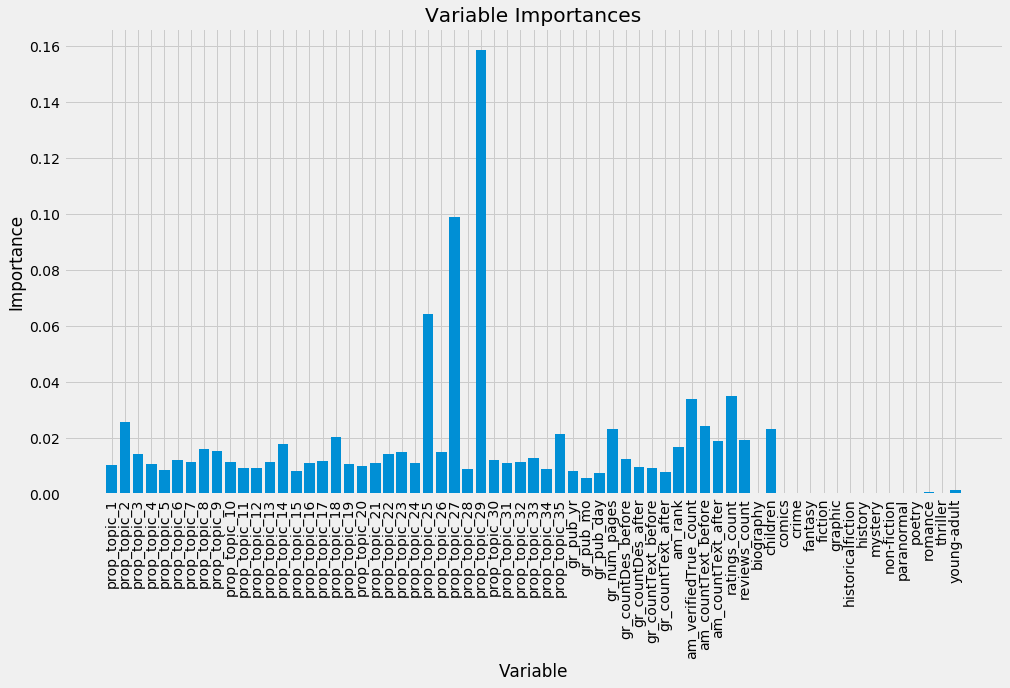

In [15]:
importances = list(rf.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 8))
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

# Xgboost

In [16]:
xgb_mallet_2 = lda_mallet.drop(['gr_format', 'gr_description', 'gr_genres', 'am_format'], axis=1) 
xgb_mallet_2 = xgb_mallet_2.dropna()
xgb_mallet_2 = pd.merge(xgb_mallet_2, genres, how='left', on='asin')
xgb_mallet_2.isnull().sum()

asin            0
prop_topic_1    0
prop_topic_2    0
prop_topic_3    0
prop_topic_4    0
               ..
paranormal      0
poetry          0
romance         0
thriller        0
young-adult     0
Length: 67, dtype: int64

In [17]:
y = np.array(xgb_mallet_2['rating_diff'])
x = xgb_mallet_2.drop('asin', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
xg = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
xg.fit(x_train, y_train)

# make predictions for train data
y_pred = xg.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', np.round(mean_absolute_error(y_train, y_pred),4))
print('Mean Squared Error:', np.round(mean_squared_error(y_train, y_pred),4))
print('Root Mean Squared Error:', np.round(np.sqrt(mean_squared_error(y_train, y_pred)),4))
r2 = xg.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', np.round(adjusted_r2,4))

print('----------------------------------')

# make predictions for test data
y_pred = xg.predict(x_test)
mae_xg = np.round(mean_absolute_error(y_test, y_pred ),4)
mse_xg = np.round(mean_squared_error(y_test, y_pred),4)
rmse_xg= np.round(np.sqrt(mean_squared_error(y_test, y_pred )),4)
print('TEST DATA:')
print('Mean Absolute Error:', mae_xg )
print('Mean Squared Error:', mse_xg)
print('Root Mean Squared Error:', rmse_xg)
r2 = xg.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
r2_xg = np.round(adjusted_r2,4)
print('R2 Adjusted Score:', r2_xg )

TRAIN DATA:
Mean Absolute Error: 0.0937
Mean Squared Error: 0.0159
Root Mean Squared Error: 0.126
R2 Adjusted Score: 0.833
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2059
Mean Squared Error: 0.0736
Root Mean Squared Error: 0.2713
R2 Adjusted Score: 0.1405


# Neural Network

In [18]:
nn_mallet = lda_mallet.drop(['gr_format', 'gr_description', 'gr_genres', 'am_format'], axis=1) 
nn_mallet = nn_mallet.dropna()
nn_mallet.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
prop_topic_11            0
prop_topic_12            0
prop_topic_13            0
prop_topic_14            0
prop_topic_15            0
prop_topic_16            0
prop_topic_17            0
prop_topic_18            0
prop_topic_19            0
prop_topic_20            0
prop_topic_21            0
prop_topic_22            0
prop_topic_23            0
prop_topic_24            0
prop_topic_25            0
prop_topic_26            0
prop_topic_27            0
prop_topic_28            0
prop_topic_29            0
prop_topic_30            0
prop_topic_31            0
prop_topic_32            0
prop_topic_33            0
prop_topic_34            0
prop_topic_35            0
gr_pub_yr                0
g

In [19]:
nn_mallet = pd.merge(nn_mallet, genres, how='left', on='asin')
nn_mallet

,asin,prop_topic_1,prop_topic_2,prop_topic_3,prop_topic_4,prop_topic_5,prop_topic_6,prop_topic_7,prop_topic_8,prop_topic_9,...,graphic,historicalfiction,history,mystery,non-fiction,paranormal,poetry,romance,thriller,young-adult
0,0001713353,0.002965,0.006142,0.003064,0.009717,0.007532,0.002567,0.012497,0.037718,0.004156,...,0,0,0,0,0,0,0,0,0,0
1,0002007649,0.001322,0.006238,0.002341,0.003492,0.004599,0.004865,0.019789,0.005529,0.002828,...,0,0,0,0,1,0,0,0,0,0
2,0001716069,0.003595,0.008401,0.004867,0.016812,0.004443,0.005715,0.011723,0.022608,0.010097,...,0,0,0,0,0,0,1,0,0,1
3,0001841572,0.004595,0.012215,0.006101,0.039328,0.011683,0.012569,0.006810,0.007076,0.186502,...,0,1,1,0,0,1,0,0,0,1
4,0001983008,0.008206,0.005634,0.010435,0.027239,0.021409,0.003405,0.013007,0.012664,0.005805,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4176,0060753382,0.004610,0.005710,0.019571,0.060129,0.027859,0.013924,0.007177,0.006223,0.011137,...,0,0,0,1,0,0,0,0,1,0
4177,0060779381,0.001584,0.003089,0.001197,0.003390,0.003905,0.002315,0.001283,0.010396,0.002616,...,0,1,1,1,0,0,0,1,1,0
4178,0060783400,0.006066,0.020033,0.005996,0.066894,0.005367,0.344847,0.007044,0.009837,0.031347,...,0,1,1,0,1,0,0,0,0,0
4179,0060784563,0.001476,0.007901,0.001588,0.001337,0.008068,0.001057,0.006588,0.337826,0.005471,...,0,0,0,0,1,0,0,1,0,0


In [20]:
y = np.array(nn_mallet['rating_diff'])
x = nn_mallet.drop('asin', axis=1).drop('rating_diff', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
nn = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
nn.fit(x_train, y_train)

# make predictions for train data
y_pred = nn.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', np.round(mean_absolute_error(y_train, y_pred),4))
print('Mean Squared Error:', np.round(mean_squared_error(y_train, y_pred),4))
print('Root Mean Squared Error:', np.round(np.sqrt(mean_squared_error(y_train, y_pred)),4))
r2 = nn.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', np.round(adjusted_r2,4))

print('----------------------------------')

# make predictions for test data
y_pred = nn.predict(x_test)
mae_nn = np.round(mean_absolute_error(y_test, y_pred ),4)
mse_nn = np.round(mean_squared_error(y_test, y_pred) ,4)
rmse_nn= np.round(np.sqrt(mean_squared_error(y_test, y_pred )),4)
print('TEST DATA:')
print('Mean Absolute Error:', mae_nn )
print('Mean Squared Error:', mse_nn)
print('Root Mean Squared Error:', rmse_nn)
r2 = nn.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
r2_nn = np.round(adjusted_r2,4)
print('R2 Adjusted Score:', r2_nn )

TRAIN DATA:
Mean Absolute Error: 0.1637
Mean Squared Error: 0.045
Root Mean Squared Error: 0.2122
R2 Adjusted Score: 0.5269
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2521
Mean Squared Error: 0.1052
Root Mean Squared Error: 0.3243
R2 Adjusted Score: -0.2283


C:\Users\Tien Nguyen\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Comparing the 3 models

In [21]:
mse = pd.DataFrame(data ={'Algorithms': ["Random Forest","Random Forest",'Random Forest',"Random Forest",'XGBoost','XGBoost','XGBoost','XGBoost','Neural Network','Neural Network','Neural Network','Neural Network'], 
                                 'Score': [mae_rf, mse_rf,rmse_rf,r2_rf,mae_xg, mse_xg,rmse_xg,r2_xg,mae_nn, mse_nn,rmse_nn,r2_nn],
                      'Dataset Splits': ['MAE','MSE','RMSE','R2','MAE','MSE','RMSE','R2','MAE','MSE','RMSE','R2']})

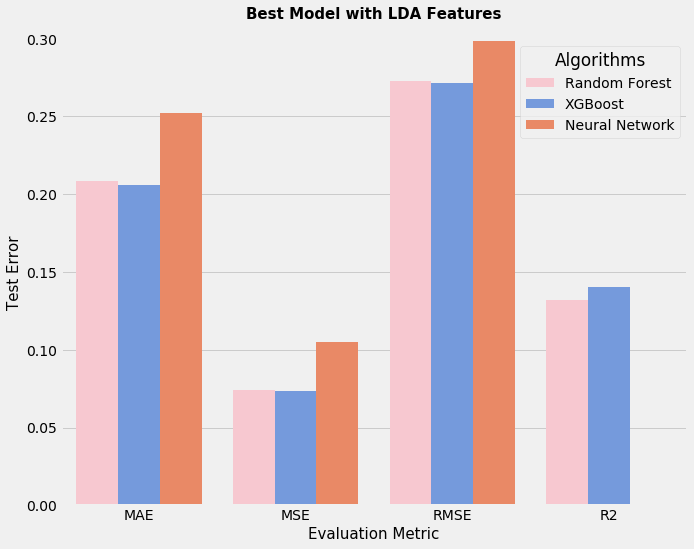

In [22]:
plt.figure(figsize=(10, 8))
sns.barplot(x="Dataset Splits", hue="Algorithms", y="Score", data= mse,capsize = 0.5, palette=["pink", "cornflowerblue", "coral"]) 
plt.title('Best Model with LDA Features', fontsize = 15,fontweight="bold",y =1.03)
plt.xlabel("Evaluation Metric",fontsize = 15)
plt.ylabel("Test Error",fontsize = 15)
plt.ylim(0,0.3)
plt.show()

# Discussion

The models test performance from best to least in order are: Xgboost > RF > NN. <br/>
But the train/test prediction difference of the models from smallest to biggest in order are: NN > Xgboost > RF. <br/>



## Test out some weighted average ensembles and compare with individual models.

After knowing that XGB performed best, then followed by RF and NN, we tested out some weighted average ensembles

In [23]:
y = np.array(nn_mallet['rating_diff'])
x = nn_mallet.drop('asin', axis=1).drop('rating_diff', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
scaler = StandardScaler()
scaler.fit(x_train)
x_train_nn = scaler.transform(x_train)
x_test_nn = scaler.transform(x_test)

In [24]:
model1_pred = np.array(rf.predict(x_train))
xg.fit(x_train, y_train)
model2_pred = np.array(xg.predict(x_train))
model3_pred = np.array(nn.predict(x_train_nn))
y_pred = ((30*model1_pred) + (60*model2_pred) + (10*model3_pred))/100
print('TRAIN DATA:')
print('Mean Absolute Error:', np.round(mean_absolute_error(y_train, y_pred),4))
print('Mean Squared Error:', np.round(mean_squared_error(y_train, y_pred),4))
print('Root Mean Squared Error:', np.round(np.sqrt(mean_squared_error(y_train, y_pred)),4))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', np.round(adjusted_r2,4))

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(rf.predict(x_test))
model2_pred = np.array(xg.predict(x_test))
model3_pred = np.array(nn.predict(x_test_nn))
y_pred = ((30*model1_pred) + (60*model2_pred) + (10*model3_pred))/100
print('TEST DATA:')
print('Mean Absolute Error:', np.round(mean_absolute_error(y_test, y_pred),4))
print('Mean Squared Error:', np.round(mean_squared_error(y_test, y_pred),4))
print('Root Mean Squared Error:', np.round(np.sqrt(mean_squared_error(y_test, y_pred)),4))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', np.round(adjusted_r2,4))

TRAIN DATA:
Mean Absolute Error: 0.1124
Mean Squared Error: 0.0226
Root Mean Squared Error: 0.1504
R2 Adjusted Score: 0.7623
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2037
Mean Squared Error: 0.0718
Root Mean Squared Error: 0.268
R2 Adjusted Score: 0.161


*********************************************************************
=> The best model with the formula: 30% * RF + 60% * XgB + 10% * NN
*********************************************************************